## Convex Hull for 3D points - **Quick Hull Algorithm**

## Input

In [ ]:
import plotly.graph_objects as go # install the necessary libraries incase of error
import numpy as np 
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import random
import timeit
import sys
import os
from math import *

In [ ]:

def readInput(filename):
  try :
    array2D=[]
    with open(filename, 'r') as f:
      for line in f.readlines()[0:]:
        lines=line.rstrip('\n')
        lines=lines.split()
        temp=[]
        for i in lines:
          temp.append(float(i))
        array2D.append(point(temp[0],temp[1],temp[2]))
    return array2D
  except:
  # code for reading Input
    inp = []
    x=[0, 0, 1, 1, 0, 0, 1, 1]
    y=[0, 1, 1, 0, 0, 1, 1, 0]
    z=[0, 0, 0, 0, 1, 1, 1, 1]
    for i in range(0,8):
      inp.append(point(x[i],y[i],z[i]))
  return  inp

In [ ]:
def printf(points):
  for i in points:
    print(i.x, i.y, i.z)

## step 1

### 1.1

In [ ]:
## Extreme points
def isMin(x,y):
  return x<y
def isMax(x,y):
  return x>y

def extremePoints(points):
  if (len(points) <4):
    print("Invalid number of points")
    sys.exit()
  xMin = xMax = yMin = yMax = zMin = zMax = points[0]
  N = len(points)

  for p in points:
    
    if (xMin.x>p.x):
      xMin = p
    if (xMax.x<p.x):
      xMax = p
    
    if ( p.y<yMin.y):
      yMin = p
    if (p.y>yMax.y):
      yMax = p

    if (p.z<zMin.z ):
      zMin = p
    if ( p.z>zMax.z ):
      zMax = p
    
  ep = [xMin, xMax, yMin, yMax, zMin, zMax]
  return ep


In [ ]:
# classes used for storing points, planes
class point:
  def __init__ (self, x,y,z):
    self.x = x
    self.y = y
    self.z = z

  def euclideanDist(self, p2):
    xdist = (self.x - p2.x)**2
    ydist = (self.y - p2.y)**2
    zdist = (self.z - p2.z)**2
    return sqrt(xdist + ydist +zdist)

  def dotprod(self,p2):
    return self.x*p2.x + self.y*p2.y + self.z*p2.z

  def crossprod(self,p2):
    x1 = self.y*p2.z - self.z*p2.y
    y1 = -(self.x*p2.z - self.z*p2.x)
    z1 = self.x*p2.y - self.y*p2.x
    return point(x1,y1,z1)

  def normalisedV(self):
    # printf([self])
    mag = self.euclideanDist(point(0,0,0))
    return point(self.x/mag, self.y/mag, self.z/mag)

  def diff(self,p2):
    return point(self.x - p2.x, self.y - p2.y, self.z - p2.z)

  def add(self,p2):
    return point(self.x + p2.x , self.y + p2.y, self.z + p2.z)

  def div(self,x):
    return point(self.x/ x , self.y/x, self.z/x)

  def mul(self,x):
    return point(self.x*x, self.y*x, self.z*x)

In [ ]:
# Tetrahedron using the extreme points
def temp_dist(a,p):
  normi=(a[0].diff(a[1])).crossprod(a[1].diff(a[2]))
  normi=normi.normalisedV()
  return abs(normi.dotprod(p.diff(a[0])))
def createSimplex( points):
  # Extreme points
  ep = extremePoints(points)
  # printf(ep)
  # print()
  # for p in ep:
  #   print(p.x, p.y, p.z)

  # 1 - The two extreme points in the ep list [ forms base line for the simplex ]
  extP1 = ep[0]
  extP2 = ep[0]
  for p1 in ep:
    for p2 in ep:
      if ( p1.euclideanDist(p2) > extP1.euclideanDist(extP2)):      
        extP1 = p1
        extP2 = p2
  # 2 - Farthest point from the initial line [ third point needed to form triangle/ plane]
  # Reference - https://onlinemschool.com/math/library/analytic_geometry/p_line/ or  https://math.stackexchange.com/questions/1905533/find-perpendicular-distance-from-point-to-line-in-3d
  distToLine = 0
  extP3 = extP1
  extP4 = extP1
  for pt in points:
    if ( pt != extP1 and pt != extP2):
      d = (extP2.diff(extP1)).div(extP1.euclideanDist(extP2)) 
      t = d.dotprod(pt.diff(extP1)) 
      p = extP1.add( d.mul(t))
      dist = p.euclideanDist(pt)
      if (distToLine < dist):
        distToLine = dist
        extP3 = pt
  # 3 -  Farthest point from the plane [ Fourth point needed to form tetrahedron]
  distToPlane = 0
  for pt in points:
    if (pt!= extP1 and pt!= extP2 and pt!= extP3):
      dist = temp_dist([extP1,extP2,extP3],pt)
      if (dist > distToPlane):
        extP4 = pt
        distToPlane = dist
  internal_pts = [extP1, extP2, extP3, extP4] # internal points
  # visited=(internal_pts)
  return internal_pts

# printf(points)
# print()
# printf(internal_pts)

In [ ]:
def find_dist(face,pt):
  n=face.normal
  line=pt.diff(face.p1)
  return n.dotprod(line)

In [ ]:
# each facet containes 3 points, and 2d plane, 3 edges
def find_normal(a):
  normi=(a[0].diff(a[1])).crossprod(a[1].diff(a[2]))
  normi=normi.normalisedV()
  for p in internal_pts:
    dist=normi.dotprod(p.diff(a[0]))
    #printf([normi])
    #print(dist)
    if(dist>10**-5):
      normi=normi.mul(-1)
      break
  return normi
class facet:
  def __init__(self, p1, p2, p3):
    self.p1 = p1
    self.p2 = p2
    self.p3 = p3
    self.pts = set()
    self.normal=find_normal([p1,p2,p3])

  def plane_to_point_dist(self,pt):
    v1 = self.plane()
    dist = v1.dotprod(pt.diff(self.p1))
    return dist
  def update(self,lis):
    l=[]
    for i in lis:
      dist=find_dist(self,i)
      if((not i in visited) and (dist>10**-5)):
        l.append(i)
    self.pts=set(l)

## step 2
Updating the facets

In [ ]:
dic={"total_planes":0}

In [ ]:
visited=[]
visfaces = [] # stores the visible faces from farthest point
edges_list = [] # stores the edges of the horizon, used to add new facets with farthest point
sys.setrecursionlimit(10000000)

def edges(face): # returns edges of the face
  lis = []
  lis.append([face.p1,face.p2])
  lis.append([face.p2,face.p3])
  lis.append([face.p3,face.p1])
  return lis
thres = 10**-9

def checkEdge(e,l): # edges checking
  for i in l:
    if e[0]==i[0] and e[1] == i[1]:
      return 1
    if e[0]==i[1] and e[1] == i[0]:
      return 1
  return 0

def horizon(farPoint,face): # horizon
  dist = find_dist(face,farPoint)
  if (dist < thres):
    return 1
  visfaces.append(face)
  for e in edges(face):
    for neighface in req_faces:
      if (face!= neighface and checkEdge(e,edges(neighface))):
        if  (neighface not in visfaces):
          isHorizon = horizon(farPoint, neighface)
          if (isHorizon):
            edges_list.append(e)
        break
  return 0

In [ ]:

def facesUpdate(req_faces):
  while (1):
    check = 0
    for face in req_faces:
      if (len(face.pts)<=0): # Facet is already a convex hull facet
        continue
      else: # when there is a point above the plane
        # farthest point of the facet's point list
        check=1
        lis = list(face.pts)
        pt = lis[0]
        dist_max=find_dist(face,pt)
        for i in lis:
          dist=find_dist(face,i)
          if(dist>dist_max):
            dist_max=dist
            pt=i
        # pt = random.choice(lis)
        # finding the planes that are visible from the farthest point
        visfaces.clear()
        edges_list.clear()
        horizon(pt, face)
        for e in edges_list:
          nFacet = facet(e[0],e[1],pt)
          internalFacetPts = set()
          for f in visfaces:
            internalFacetPts = internalFacetPts.union(f.pts)
          nFacet.update(internalFacetPts)
          req_faces.append(nFacet)
          dic["total_planes"]+=1
        for f in visfaces:
          req_faces.remove(f)
    if (check==0):
      break

## Main

In [ ]:
def random_generate(num):
  l=[]
  for i in range(num):
    l.append(point(random.uniform(1,1000),random.uniform(1,1000),random.uniform(1,1000)))
  return l

In [ ]:
timer_quick_hull=[]
faces_quick_hull=[]
timer_inbuilt=[]
list_points=[10,20,30,40,50,60,70,80,90,100,500,1000,1500,2000,3000,3500,4000,5000]
for i in list_points:
  points=random_generate(i) ## file name
  internal_pts=createSimplex(points)
  # Creating facets using internal points
  face1=facet(internal_pts[0],internal_pts[1],internal_pts[2])
  face2=facet(internal_pts[0],internal_pts[1],internal_pts[3])
  face3=facet(internal_pts[0],internal_pts[2],internal_pts[3])
  face4=facet(internal_pts[1],internal_pts[2],internal_pts[3])
  # adding the outside points to corresponding faces
  req_faces=[face1,face3,face2,face4]
  face1.update(points)
  face2.update(points)
  face3.update(points)
  face4.update(points)
  dic["total_planes"]=4
  x1 =[]
  y1=[]
  z1 =[]
  for pt in points:
    x1.append(pt.x)
    y1.append(pt.y)
    z1.append(pt.z)



  start = timeit.default_timer()
  facesUpdate(req_faces)
  fn=timeit.default_timer()
  timer_quick_hull.append(fn-start)
  faces_quick_hull.append(dic["total_planes"])


  s=set(req_faces)
  cnt=0
  points_final=set()
  for i in req_faces:
    if(len(i.pts)==0):
      cnt+=1
      points_final.add(i.p1)
      points_final.add(i.p2)
      points_final.add(i.p3)
      # printf([i.p1,i.p2,i.p3,i.normal])
      # print()
  print("Number of planes - ",cnt,"Number of vertices -",len(points_final))

Number of planes -  12 Number of vertices - 8
Number of planes -  22 Number of vertices - 13
Number of planes -  32 Number of vertices - 18
Number of planes -  38 Number of vertices - 21
Number of planes -  42 Number of vertices - 23
Number of planes -  42 Number of vertices - 23
Number of planes -  60 Number of vertices - 32
Number of planes -  54 Number of vertices - 29
Number of planes -  56 Number of vertices - 30
Number of planes -  48 Number of vertices - 26
Number of planes -  86 Number of vertices - 45
Number of planes -  138 Number of vertices - 71
Number of planes -  164 Number of vertices - 84
Number of planes -  178 Number of vertices - 91
Number of planes -  168 Number of vertices - 86
Number of planes -  188 Number of vertices - 96
Number of planes -  176 Number of vertices - 90
Number of planes -  222 Number of vertices - 113


In [ ]:
timer_random=[]
faces_random=[]
list_points=[10,20,30,40,50,60,70,80,90,100,500,1000,1500,2000,3000,3500,4000,5000]
for i in list_points:
  points=random_generate(i) ## file name
  internal_pts=createSimplex(points)

  # Creating facets using internal points
  face1=facet(internal_pts[0],internal_pts[1],internal_pts[2])
  face2=facet(internal_pts[0],internal_pts[1],internal_pts[3])
  face3=facet(internal_pts[0],internal_pts[2],internal_pts[3])
  face4=facet(internal_pts[1],internal_pts[2],internal_pts[3])
  # adding the outside points to corresponding faces
  req_faces=[face1,face3,face2,face4]
  face1.update(points)
  face2.update(points)
  face3.update(points)
  face4.update(points)
  dic["total_planes"]=4
  start = timeit.default_timer()
  facesUpdate(req_faces)
  fn=timeit.default_timer()
  timer_random.append(fn-start)
  faces_random.append(dic["total_planes"])

  s=set(req_faces)
  cnt=0
  points_final=set()
  for i in req_faces:
    if(len(i.pts)==0):
      cnt+=1
      points_final.add(i.p1)
      points_final.add(i.p2)
      points_final.add(i.p3)
      # printf([i.p1,i.p2,i.p3,i.normal])
      # print()
  print("Number of planes - ",cnt,"Number of vertices -",len(points_final))

Number of planes -  12 Number of vertices - 8
Number of planes -  26 Number of vertices - 15
Number of planes -  34 Number of vertices - 19
Number of planes -  42 Number of vertices - 23
Number of planes -  38 Number of vertices - 21
Number of planes -  46 Number of vertices - 25
Number of planes -  50 Number of vertices - 27
Number of planes -  58 Number of vertices - 31
Number of planes -  46 Number of vertices - 25
Number of planes -  58 Number of vertices - 31
Number of planes -  112 Number of vertices - 58
Number of planes -  116 Number of vertices - 60
Number of planes -  150 Number of vertices - 77
Number of planes -  172 Number of vertices - 88
Number of planes -  170 Number of vertices - 87
Number of planes -  196 Number of vertices - 100
Number of planes -  168 Number of vertices - 86
Number of planes -  252 Number of vertices - 128


In [ ]:
def brute(input):
  points=random_generate(input)
  def check_dist(face,point):
    pt1=face.p1
    pt2=face.p2
    pt3=face.p3
    n=pt1.diff(pt2).crossprod(pt1.diff(pt3))
    n=n.normalisedV()
    line=point.diff(face.p1)
    return n.dotprod(line)
  def check(face):
    s=set()
    for i in points:
      if(i==face.p1 or i==face.p2 or i==face.p3):
        continue
      if(check_dist(face,i) > 10**-10):
        s.add(1)
      else :
        s.add(-1)
      if(len(s)>1):
        return 0
    return 1
  N=len(points)
  l=[]
  l_planes=set()
  ans=0
  final=0
  for i in range(N):
    for j in range(i+1,N):
      for k in range(j+1,N):
        ans+=1
        if(check(facet(points[i],points[j],points[k]))):
          l_planes.add(facet(points[i],points[j],points[k]))
  print(len(l_planes))
  return ans

In [ ]:
time_brute=[]
faces_brute=[]
import time
for i in list_points[:10]:
  st=time.time()
  faces_brute.append(brute(i))
  fn=time.time()
  time_brute.append(fn-st)

14
26
26
38
48
44
52
58
50
58


In [ ]:
print(timer_random,'\n',timer_quick_hull,'\n',time_brute)

[0.0006356289995892439, 0.00299279499995464, 0.004234248999637202, 0.013589467000201694, 0.012122007001380553, 0.015293640999516356, 0.013228390000222134, 0.012170899000921054, 0.011020419000487891, 0.016148409000379615, 0.07995784000013373, 0.11877485799959686, 0.1684146759998839, 0.2513864590000594, 0.2829366360001586, 0.339586774000054, 0.39432867700088536, 0.5410459390004689] 
 [0.000672858999678283, 0.0017993250003200956, 0.0028391330015438143, 0.003682806000142591, 0.004357780999271199, 0.0037943509996694047, 0.02055282699984673, 0.007695428001170512, 0.007591605000925483, 0.00672914900133037, 0.03302542799974617, 0.05365939900002559, 0.08134706399869174, 0.08100770099918009, 0.13488991600024747, 0.12518655699932424, 0.122133508000843, 0.19210504799957562] 
 [0.00653386116027832, 0.07363557815551758, 0.20542693138122559, 0.380786657333374, 0.832305908203125, 1.5619990825653076, 2.289327621459961, 2.883169174194336, 4.852898359298706, 6.316635608673096]


### Time Comparison

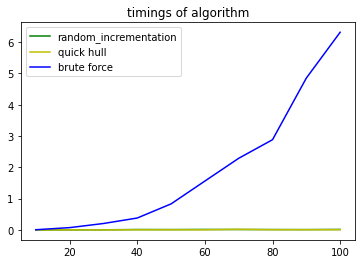

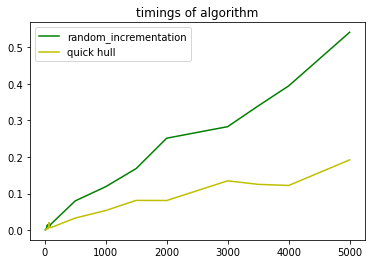

In [ ]:
import matplotlib.pyplot as plt
plt.title('timings of algorithm')
plt.plot(list_points[:10],timer_random[:10],color='g',label='random_incrementation')
plt.plot(list_points[:10],timer_quick_hull[:10],color='y',label='quick hull')
plt.plot(list_points[:10],time_brute[:10],color='b',label='brute force')
plt.legend()
plt.figure()
plt.title('timings of algorithm')
plt.plot(list_points,timer_random,color='g',label='random_incrementation')
plt.plot(list_points,timer_quick_hull,color='y',label='quick hull')
# plt.plot(time_brute[:10],color='b',label='brute force')
plt.legend()

### Faces comparison

In [ ]:
print(faces_random,'\n',faces_quick_hull,'\n',faces_brute)

[22, 61, 79, 110, 90, 139, 155, 147, 136, 159, 407, 497, 600, 783, 637, 935, 883, 1050] 
 [18, 41, 63, 76, 84, 76, 128, 105, 110, 98, 198, 303, 378, 403, 383, 421, 390, 501] 
 [120, 1140, 4060, 9880, 19600, 34220, 54740, 82160, 117480, 161700]


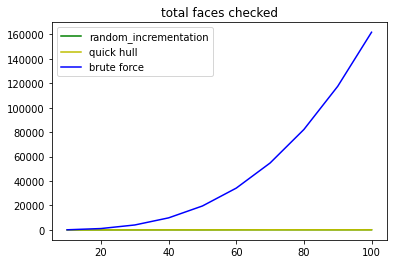

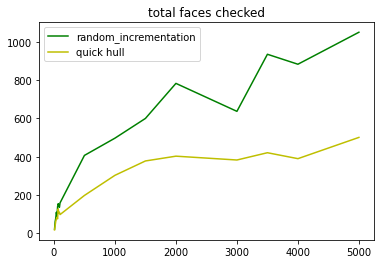

In [ ]:
import matplotlib.pyplot as plt
plt.title('total faces checked')
plt.plot(list_points[:10],faces_random[:10],color='g',label='random_incrementation')
plt.plot(list_points[:10],faces_quick_hull[:10],color='y',label='quick hull')
plt.plot(list_points[:10],faces_brute[:10],color='b',label='brute force')
plt.legend()
plt.figure()
plt.title('total faces checked')
plt.plot(list_points,faces_random,color='g',label='random_incrementation')
plt.plot(list_points,faces_quick_hull,color='y',label='quick hull')
# plt.plot(time_brute[:10],color='b',label='brute force')
plt.legend()

Time in secs 

faces and time as a tuple

| points | quick hull | random incremental | brute force | final external points | final external faces |  
| ----- | ---- | --- | ------ | --------| ---------|
| 10 | (22,0.00055)|(26,0.00074)|(120,0.00653)|9|14|
| 20 |(45,0.00190)| (50,0.00204)|(1140,0.07363)|14|24|
| 30 |(62,0.00258)|(68,0.00286)|(4060,0.20542)|18|32|
| 40 |(67,0.00546)|(104,0.00895)|(9880,0.38078)|20|36|
| 50 | (103,0.00609)|(118,0.01044)|(19600,0.83230)|27|50|
| 60 | (79,0.00429)|(139,0.010295)|(34220,1.56199)|23|42|
| 70 |(92,0.00618)|(125,0.01164)|(54740,2.28932)|27|50|
| 80 | (93,0.00969)|(128,0.01004)|(82160,2.88316)|26|48|
| 90 |(152,0.01526)|(148,0.01547)|(117480,4.85289)|37|70|
|100|(143,0.01702)|(203,0.02552)|(161700,6.31663)|34|64|
|500|(221,0.03119)|(509,0.1255)|()|54|104|
| 1000|(294,0.05998)|(548,0.15100)|()|72|140|
| 1500 |(340,0.07090)|(528,0.14523)|()|75|146|
|2000|(406,0.10750)|(825,0.34044)|()|87|170|
|3000|(399,0.11971)|(672,0.28369)|()|91|178|
|3500|(347,0.10741)|(9540,0.40385)|()|79|154|
|4000|(471,0.15421)|(909,0.42963)|()|101|198|
|5000|(442,0.18248)|(1035,0.56535)|()|99|194|